#MultiClass Image Classification Using PyTorch



##About Dataset

Fashion-MNIST, a dataset by Zalando, comprises 60,000 training examples and 10,000 test examples of 28x28 grayscale images, each associated with one of 10 classes. Zalando designed it as a drop-in replacement for MNIST, maintaining the same image size and training/testing splits. MNIST, known for handwritten digits, serves as a benchmark for machine learning. Zalando's goal is to replace MNIST in the AI/ML community.

Each image's 784 pixels range from 0 to 255, indicating lightness or darkness. The dataset has 785 columns, with the first containing class labels. Pixels are located on a 28x28 matrix, with pixel31, for example, in the fourth column from the left and the second row from the top.

Download Dataset file: https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [1]:
#Importing Libraries

import os
import time
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils
from torchsummary import summary
from sklearn.metrics import accuracy_score, confusion_matrix

from PIL import Image

## 1. CSV File Loading

In [6]:

train_path = '/content/fashion-mnist_train.csv'
test_path = '/content/fashion-mnist_test.csv'


In [7]:
train_df = pd.read_csv(train_path)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df = pd.read_csv(test_path)
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(train_df.shape)
print(train_df.info())

(60000, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None


In [10]:
print(test_df.shape)
print(test_df.info())

(10000, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None


In [11]:
train_df.iloc[0, 1:].max()

255

In [12]:
train_df['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [13]:
test_df['label'].value_counts()

0    1000
1    1000
2    1000
3    1000
8    1000
6    1000
5    1000
4    1000
7    1000
9    1000
Name: label, dtype: int64

## 2. Format into images

Loading all the data in the CSV file is not memory efficient. Also, We cannot understand the data in raw format. Hence, we have to  format this file into images in the following format.

* train/0/xxx.png
* train/1/xxx.png
* train/2/xx.png

In [14]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [15]:
# Set the directory paths
train_path = '/content/train'
test_path = '/content/test'



In [16]:
# Create directories if they do not exist
for path in [train_path, test_path]:
    if not os.path.exists(path):
        os.makedirs(path)



In [17]:
# Get unique class labels
class_labels = train_df['label'].unique().tolist()



In [18]:
# Create directories for each class label within train_path and test_path
for path in [train_path, test_path]:
    for class_label in class_labels:
        class_path = os.path.join(path, str(class_label))
        if not os.path.exists(class_path):
            os.makedirs(class_path)

In [19]:
for row_id, row in tqdm(train_df.iterrows(), total=len(train_df)):
    label = row['label']
    image_path = os.path.join("train", str(label), "{}.png".format(row_id))
    pixels = row.iloc[1:].values.astype("uint8")
    pixels = pixels.reshape(28, 28)
    image = Image.fromarray(pixels)
    image.save(image_path)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [20]:
for row_id, row in tqdm(test_df.iterrows(), total=len(test_df)):
    label = row['label']
    image_path = os.path.join("test", str(label), "{}.png".format(row_id))
    pixels = row.iloc[1:].values.astype("uint8")
    pixels = pixels.reshape(28, 28)
    image = Image.fromarray(pixels)
    image.save(image_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

## 3. Define dataset

In [21]:
#data_path = os.path.join("storage", "data", "fashion-mnist")
train_path = os.path.join("/content/train")
test_path = os.path.join("/content/test")
print(train_path, test_path)

/content/train /content/test


In [22]:
mean = 0.5
sd = 0.5
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (sd, ))
])

In [23]:
train_set = datasets.ImageFolder(root=train_path, transform=transform)
test_set = datasets.ImageFolder(root=test_path, transform=transform)

## 4. Define dataloader

In [24]:
train_batch_size = 64
test_batch_size = 4

In [25]:
num_cpus = os.cpu_count()
print(num_cpus)

2


In [26]:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_cpus)
test_loader = DataLoader(test_set, batch_size=4, shuffle=test_batch_size, num_workers=num_cpus)

In [27]:
len_train_loader = len(train_loader)
print(len_train_loader)

938


## 5. Define utilities

In [28]:
label_to_name = {
    "0": "t-shirt",
    "1": "trouser",
    "2": "pullover",
    "3": "dress",
    "4": "coat",
    "5": "sandal",
    "6": "shirt",
    "7": "sneaker",
    "8": "bag",
    "9": "ankle_boot"
}

In [29]:
name_to_label = {v: k for k, v in label_to_name.items()}
print(name_to_label)

{'t-shirt': '0', 'trouser': '1', 'pullover': '2', 'dress': '3', 'coat': '4', 'sandal': '5', 'shirt': '6', 'sneaker': '7', 'bag': '8', 'ankle_boot': '9'}


In [30]:
def plot_image(image_tensor, title=""):
    """
    Arguments:
    image_tensor -- tensor of Size([1, n_h, n_w]) / Size([3, n_h+4, n_w*m+4])
    """
    # image_tensor.squeeze() -> doesn't work for grids of Size([3, n_h+4, n_c*m+4])
    image_tensor = image_tensor.mean(dim = 0) # Size([28, 28])
    image_tensor = (image_tensor * sd) + mean
    image_tensor = image_tensor * 255 # not necessary
    image_array = image_tensor.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(image_array, cmap='Greys')
    plt.title(title)
    return plt.show()

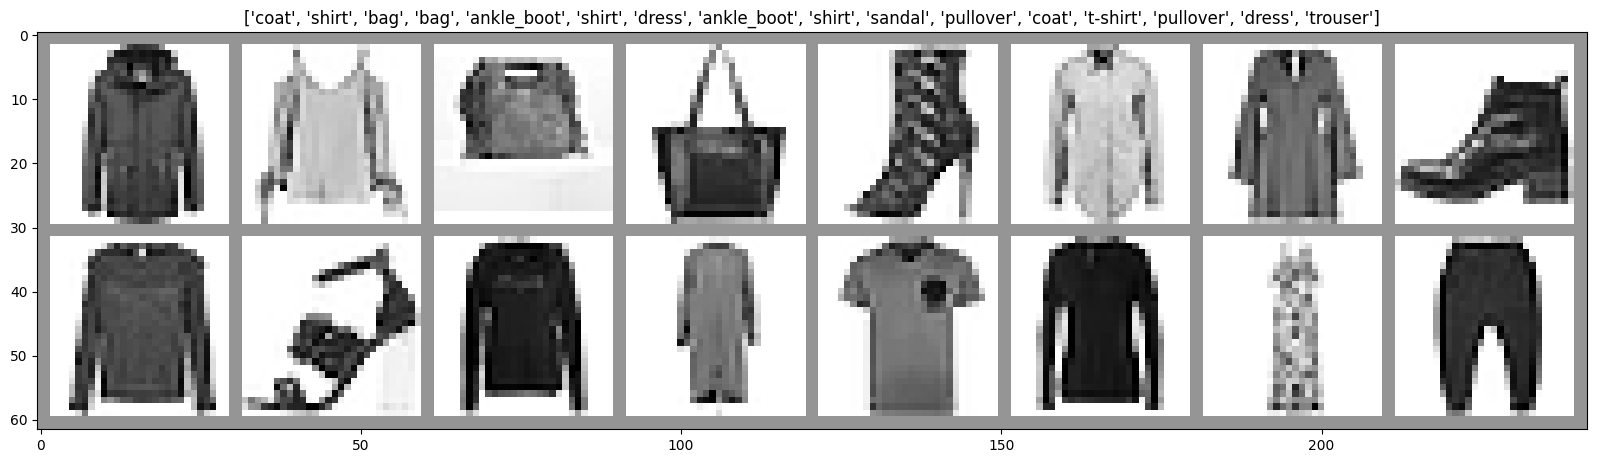

In [31]:
for batch in train_loader:
    X, Y = batch
    m = min(16, len(train_loader))
    image_grid = utils.make_grid(X[:m])
    names = [label_to_name[str(label.item())] for label in Y[:m]]
    plot_image(image_grid, title=names)
    break  # This is added to only process the first batch for demonstration purposes


## 6. Define model

In [32]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


The following architecture is modified from the LeNet

In [33]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # [m, 6, 24, 24]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # [m, 6, 12, 12]
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # [m, 16, 8, 8]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # [m, 16, 4, 4]
        self.fc3 = nn.Linear(in_features=16*4*4, out_features=120) # [m, 120]
        self.fc4 = nn.Linear(in_features=120, out_features=84) # [m, 84]
        self.fc5 = nn.Linear(in_features=84, out_features=10) # [m, 10]

    def forward(self, X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = X.view(-1, 16*4*4)
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        return X

In [34]:
model = Model()
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc3): Linear(in_features=256, out_features=120, bias=True)
    (fc4): Linear(in_features=120, out_features=84, bias=True)
    (fc5): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
#list(model.parameters())

In [35]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
             Model-8                   [-1, 10]               0
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


## 7. Set optimizer

In [37]:
lr = 0.001
step_size = len(train_loader) * 4
gamma = 0.95
print(step_size)

3752


In [38]:
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

## 8. Train model

In [39]:
epochs = 20
print_every_n_epochs = 1

In [40]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1)):
    epoch_loss = 0
    epoch_lr = 0

    for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch)):
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]

    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)

    if epoch % print_every_n_epochs == 0:
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch:1    Loss:0.6499487458070966    LR:0.0010000000000000007


Epoch-2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:2    Loss:0.4171666197780607    LR:0.0010000000000000007


Epoch-3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:3    Loss:0.35700764422858955    LR:0.0010000000000000007


Epoch-4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:4    Loss:0.32359559687057027    LR:0.000999896055437101


Epoch-5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:5    Loss:0.2980423992408364    LR:0.000950000000000006


Epoch-6:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:6    Loss:0.27908083238899073    LR:0.000950000000000006


Epoch-7:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:7    Loss:0.26514908547467514    LR:0.000950000000000006


Epoch-8:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:8    Loss:0.2535650284448539    LR:0.0009499012526652512


Epoch-9:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:9    Loss:0.23903463639890843    LR:0.0009025000000000037


Epoch-10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:10    Loss:0.22842438594062828    LR:0.0009025000000000037


Epoch-11:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:11    Loss:0.22023663777452923    LR:0.0009025000000000037


Epoch-12:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:12    Loss:0.21181241318440513    LR:0.0009024061900319866


Epoch-13:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:13    Loss:0.1999025131260027    LR:0.0008573750000000151


Epoch-14:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:14    Loss:0.1932016877787136    LR:0.0008573750000000151


Epoch-15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:15    Loss:0.1862075188453359    LR:0.0008573750000000151


Epoch-16:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:16    Loss:0.17967474380377005    LR:0.0008572858805303989


Epoch-17:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:17    Loss:0.17269222072160828    LR:0.000814506250000011


Epoch-18:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:18    Loss:0.16399720584008612    LR:0.000814506250000011


Epoch-19:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:19    Loss:0.1575137970409096    LR:0.000814506250000011


Epoch-20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:20    Loss:0.15228190766111302    LR:0.0008144215865038757


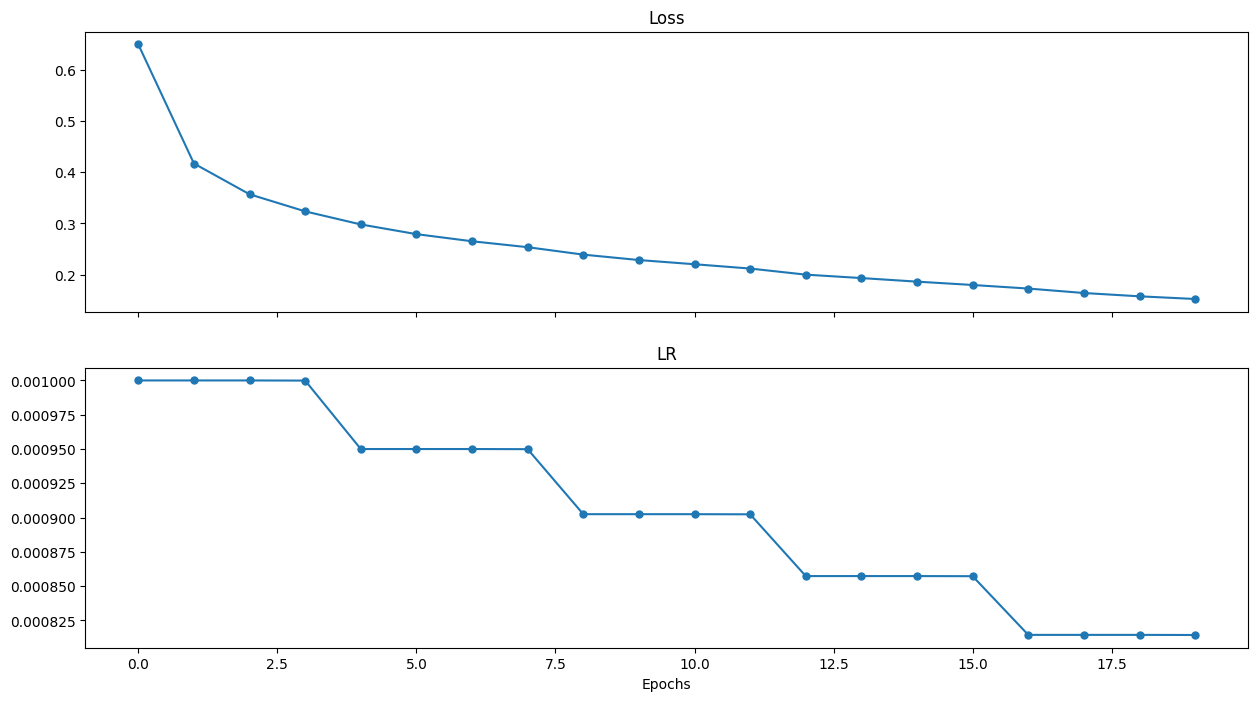

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

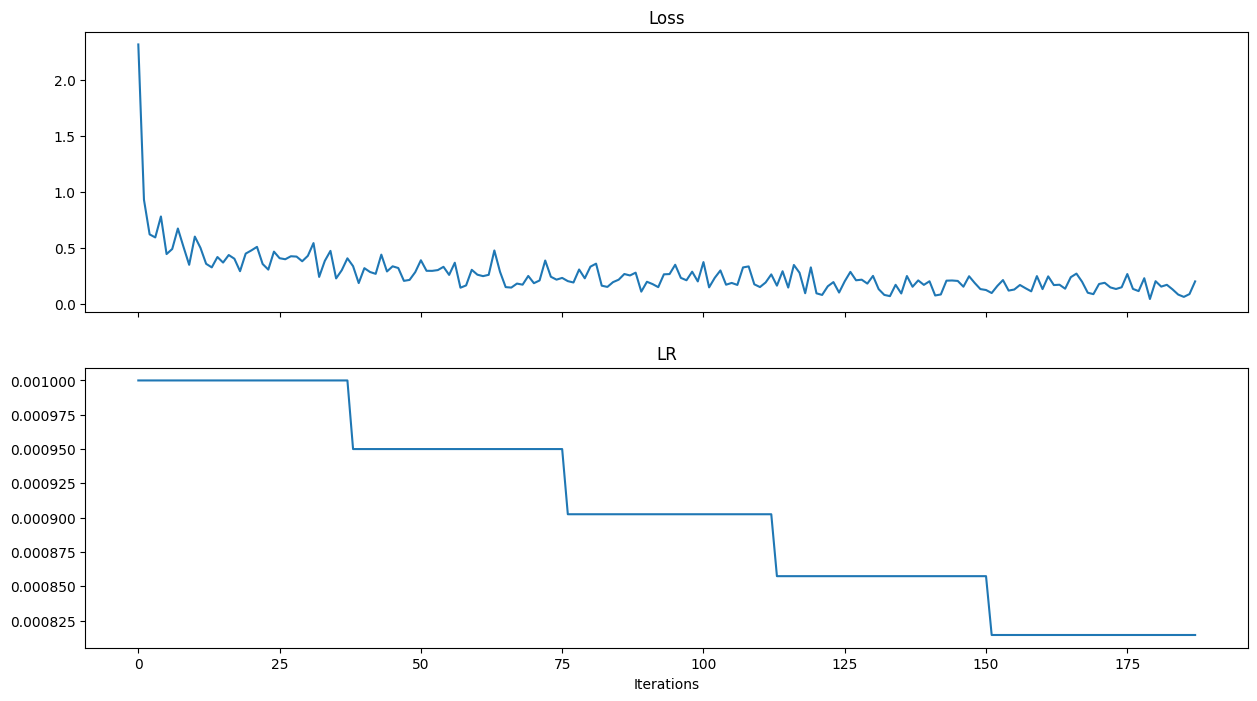

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::100])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::100])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

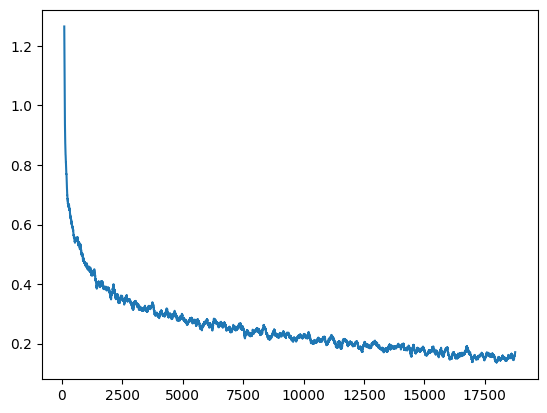

In [43]:
window = 100
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [ ]:

# Save the model
path = os.path.join("storage", "models", "fashion-mnist", "classifier.pth")

# Create directories if they don't exist
os.makedirs(os.path.dirname(path), exist_ok=True)

# Save the model's state dictionary
torch.save(model.state_dict(), path)


## 9. Test model

In [47]:
path = os.path.join("storage", "models", "fashion-mnist", "classifier.pth")
model = Model()
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))
#model = model.to("cpu")

<All keys matched successfully>

In [48]:
for p in model.parameters():
    print(p.is_cuda)

True
True
True
True
True
True
True
True
True
True


In [49]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/938 [00:00<?, ?it/s]

In [50]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/2500 [00:00<?, ?it/s]

In [51]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Train Accuracy: {}".format(train_accuracy))
print("Test Accuracy: {}".format(test_accuracy))

Train Accuracy: 0.946
Test Accuracy: 0.9004


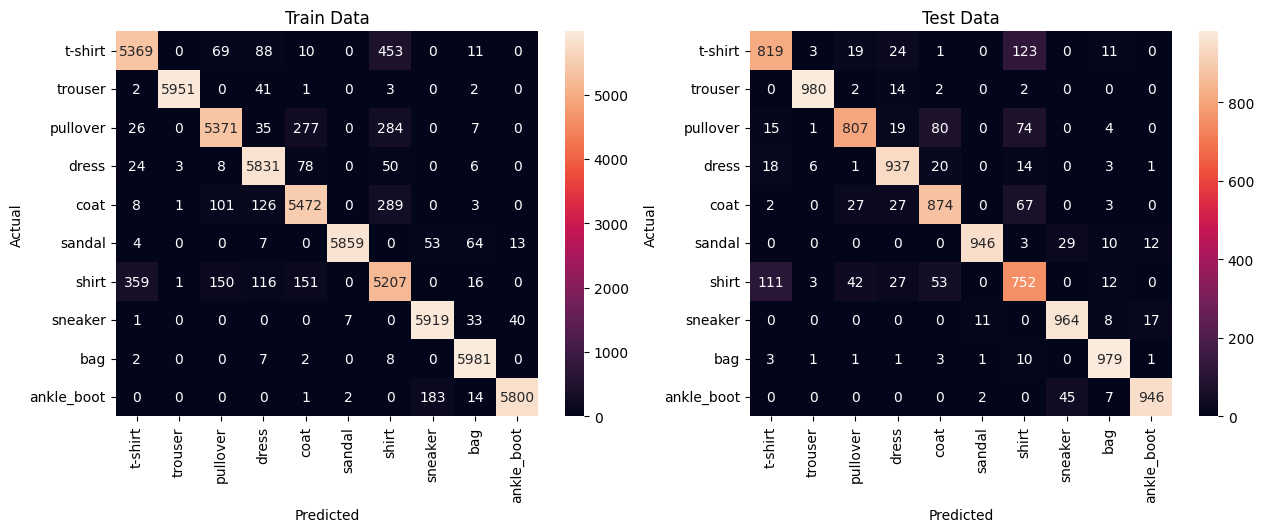

In [52]:
labels = [label_to_name[str(i)] for i in range(10)]
c_mat_train = confusion_matrix(Y_train, Y_pred_train)
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(c_mat_train, annot=True, fmt='d', ax=ax1, xticklabels=labels, yticklabels=labels)
ax1.set_title('Train Data')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
sns.heatmap(c_mat_test, annot=True, fmt='d', ax=ax2, xticklabels=labels, yticklabels=labels)
ax2.set_title('Test Data')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
plt.show()

In [53]:
def compute_accuracies(c_mat):
    accuracies = c_mat.astype('float') / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k, v in zip(labels, accuracies)}
    return accuracies

In [54]:
compute_accuracies(c_mat_train)

{'t-shirt': 0.8948333333333334,
 'trouser': 0.9918333333333333,
 'pullover': 0.8951666666666667,
 'dress': 0.9718333333333333,
 'coat': 0.912,
 'sandal': 0.9765,
 'shirt': 0.8678333333333333,
 'sneaker': 0.9865,
 'bag': 0.9968333333333333,
 'ankle_boot': 0.9666666666666667}

In [55]:
compute_accuracies(c_mat_test)

{'t-shirt': 0.819,
 'trouser': 0.98,
 'pullover': 0.807,
 'dress': 0.937,
 'coat': 0.874,
 'sandal': 0.946,
 'shirt': 0.752,
 'sneaker': 0.964,
 'bag': 0.979,
 'ankle_boot': 0.946}

The trained model achieved a high accuracy of 94.6% on the training dataset, demonstrating effective learning on the Fashion-MNIST images. Furthermore, the model maintained a solid 90.04% accuracy on the test dataset, indicating its ability to generalize well to unseen data.These results showcase strong overall performance on both the training and test datasets, with high accuracy and balanced accuracies across individual classes. The model demonstrates proficiency in recognizing diverse fashion items represented in the Fashion-MNIST dataset.